# 機械学習
## 非線形回帰

- 非線形の回帰の例  
$y=w_0+w_ix+2_2x^2+w_3x^3$  
$y=w_0+w_1\sin x+w_2\cos x+w_3\log x$  
など。多乗項やsin項などが入る。つまりxの代わりに、$\phi (x)$を用いる。  
パラメータについては線形の時と同じ！(linear-in-parameter)  
※ ということは、各成分について、$\phi (x)$を計算して、重回帰分析すれば、非線形回帰も線形回帰のアルゴリズムそのままでできそう。計算量は別だが……。  
これらは、「線形モデルによる非線形回帰」といえる。

- 基底関数  
上記の$\phi (x)$を基底関数と呼ぶ。よく使う基底関数として、
 1. 多次式：$phi (x) = x^i$  
 2. ガウス型：$\exp \left( -\frac{(x-\mu_i)^2}{\sigma ^2} \right)$  
 関数の位置を調整するのが$\mu$、広がりを制御しているのが$h_i$や$\sigma$

- 基底展開法  
線形関数のxのところを$\phi (x)$に置き換えることで、線形回帰と同じ枠組みで推定可能  
つまり、  
$$
\hat{\mathbb{w}}=(\Phi ^{(train)T}\Phi ^{(train)})^{-1}\Phi ^{(train)T}\mathbb{y}^{(train)}
$$  
ここから、
$$
\hat{\mathbb{y}} = \Phi_*\hat{\mathbb{w}} = \Phi_*(\Phi ^{(train)T}\Phi ^{(train)})^{-1}\Phi ^{(train)T}\mathbb{y}^{(train)}
$$

- 未学習と過学習  
表現力が低すぎると、分析したい現象を十分に分析できない。（未学習）  
表現力が高すぎると、具体的な測定点（学習データ）に過度に適合し、未知データの説明が難しくなる（汎化性能が低い：過学習）  
過学習への対策  
 1. 学習データを増やす  
 2. 不要な基底関数を削除して表現力を抑制（特徴量選択）（AICによるモデル選択、など）  
 3. 正則化法を利用して表現力を抑止（wが大きくなりすぎないようにする。L1,L2正則化など）⇒（Lasso,Ridgeなど）  
 モデルの複雑さが上がった時に、罰則項を設ける。

#### - 正則化法
$$
\hat{\mathbb{y}} = X_*\hat{\mathbb{w}} =X_*(X ^{(train)T}X ^{(train)})^{-1}X ^{(train)T}\mathbb{y}^{(train)}
$$  
この係数部分が極めて大きくなってしまうのは、$(X ^{(train)T}X ^{(train)})$の部分が逆行列を持たないとき。  
※ちょうど、0に極めて小さい数で割り算すると、$\pm \infty$に発散するようなもの（？）  
Xの成分ベクトルがほとんど平行になっていると、逆行列の要素が極端に大きくなってしまう。  
そこで、wが大きくなるとき（Xの成分ベクトルのいくつかが平行に近くなっているとき）は、罰則項が大きくなるような項を追加する。
$$
E(\mathbb{w})=J(\mathbb{w})+\lambda \mathbb{w}^T \mathbb{w} 
$$  
第二項がwが大きくなりすぎないように制御している。$\lambda$はハイパーパラメータ。  
一般的には、
$$
S_\gamma = (\mathbb{y}-\Phi \mathbb{w})^T(\mathbb{y}-\Phi \mathbb{w}) + \gamma R(\mathbb{w})
$$  
$\gamma$はハイパーパラメータ。正則化項の式Rの決め方は様々考えられる。  
今解くのは、
$$\min MSE s.t. R(\mathbb{w})\leq r$$
不等式条件の付いた、最適化問題  
KKT条件(ラグランジュのための条件のこと？)より、
$$\min MSE + \lambda R(\mathbb{w})$$

- ホールドアウト法  
有限のデータを学習用とテスト用の2つに分割し、「予測精度」や「誤り率」を推定するために使用する。  
学習そのものの制度と、性能評価の制度のトレードオフがある。  
データが大量にあるときはうまく機能する。  
最初に検証データを決めてしまうが故に、データが少ないと外れ値の影響を受けやすい。  
- クロスバリデーション（交差検証）  
k分割して、検証用のデータを入れ替えながらモデルを構築して、最適パラメータ（最適モデル）を探す。  
- 制度の計測方法  
最も良いのは、検証データでの最小二乗誤差。損失関数の選び方はいくつか考えられるが、原則として、学習誤差と検証誤差は同じ損失関数をしたほうが良い。  
- グリッドサーチ  
ハイパーパラメータを決める時に、チューイングパラメータをすべての組み合わせで評価値を算出して、いいパラメータを探す。  
現実的にはベイズ最適化の方が使われる。

### 実装  
以下、モデルデータを作成して、多項式回帰を実装する。

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class sample_data_maker():
    def __init__(self, n_sample, var):
        self.n_sample = n_sample
        self.var = var
    
    def sin_func(self, x):
        '''周期1のサイン波'''
        return np.sin(2 * np.pi * x)
    
    def add_noise(self, y_true):
        return y_true + np.random.normal(scale=self.var, size=y_true.shape)
    
    def make_sample(self, xs):
        ys_true = self.sin_func(xs)
        ys = self.add_noise(ys_true)
        return ys_true, ys

In [6]:
def plt_result(xs, ys_true, ys):
    plt.scatter(xs, ys, facecolor = "none", edgecolor = "b", s=50, label = "training data")
    plt.plot(xs, ys_true, label = "$\sin (2\pi x)$")
    plt.legend()

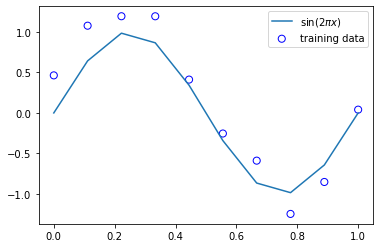

In [12]:
n_sample = 10
var = .25

maker = sample_data_maker(n_sample = n_sample, var = var)
xs = np.linspace(0,1,n_sample)
ys_true, ys = maker.make_sample(xs)

plt_result(xs,ys_true,ys)
plt.show()

In [16]:
class PolyPredictor():
    def __init__(self,degree):
        self.degree = degree
        
    def fit(self, xs, ys):
        self.xs = xs
        self.ys = ys
        self.X = self.polynomial_features(self.xs)
        self.w = np.dot(np.dot(np.linalg.inv(np.dot(self.X.T, self.X)),self.X.T), self.ys)
        
    def polynomial_features(self, xs):
        X = np.ones((len(xs), degree + 1))
        X_t =  X.T
        for i in range(1, degree+1):
            X_t[i] = X_t[i-1] * xs
        return X_t.T
    
    def predict(self, xs):
        X_test = self.polynomial_features(xs)
        return np.dot(X_test, self.w)

In [17]:
degree = 3
polyPredictor = PolyPredictor(degree = degree)
polyPredictor.fit(xs, ys)
ys_pred = polyPredictor.predict(xs)

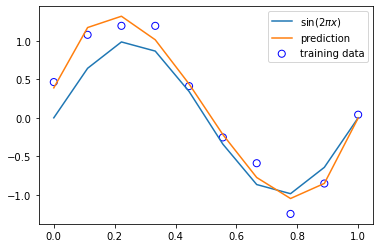

In [18]:
plt.scatter(xs, ys, facecolor = "none", edgecolor = "b", s = 50, label="training data")
plt.plot(xs, ys_true, label ="$\sin (2\pi x)$")
plt.plot(xs, ys_pred, label ="prediction")

plt.legend()
plt.show()